This research is dedicated to an application that sells food products
We need to investigate user behavior for our
company's app.

**First we will study the sales funnel.**
* Find out how users reach the purchase stage. 
* How many users actually
make it to this stage? 
* How many get stuck at previous stages? 
* Which stages in particular? 


Then we will look at the results of an A/A/B test. The essense of the experiment is:

> The designers would like to change the fonts for the entire app, but the managers are afraid the users might find the new design intimidating. 

The managers decide to make a decision based on the results of an
A/A/B test.

**The progress of the experiment:**


1. Understanding business problem & data characteristics
2. Detect and resolve problems in the data (Missing Value, Outliers, Unexpected Value)
3. Look summary stats and plots
4. Apply hypothesis testing and check assumptions:
 - For two control groups
 - For control groups by events
 - For each one of the control groups compared to the test group
 - Fot united control groups in comparison to the test group
5. Check normality & homogeneity
6. Apply tests (Shapiro, Levene Test, T-Test, Z-proportion test, Mann Whitney U Test)
7. Evaluate the results
8. Make conclusions and recommendations

##  Step 1. Open the data file and read the general information


In [ ]:
# Import libraries:

# Basic libraries
import pandas as pd
import datetime as dt
import numpy as np

# Visualistaion tools
import math as mth
import matplotlib.pyplot as plt
import seaborn as sns
from plotly import graph_objects as go
import plotly.express as px
import plotly.graph_objs as go
import plotly.io as plt_io
from plotly.subplots import make_subplots

# Statistics

from scipy import stats
import statsmodels.api as sm

# Configuration

import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_colwidth', 1)

In [ ]:
# Load the data
try:
    data = pd.read_csv('/content/drive/MyDrive/csv_fies/logs_exp_us.csv', sep='\t')
except:
    data = pd.read_csv('/datasets/logs_exp_us.csv', sep='\t')    

In [ ]:
# Explore the data
print('DATA FRAME VIEW')
print(data.head())
print('-'*80)
print('INFO')
print(data.info())
print('-'*80)
print('MISSING VALUES:')
print(data.isnull().sum())
print('-'*80)
print('There are', data.shape[0], 'rows and', data.shape[1], 'columns in our dataset')

DATA FRAME VIEW
                 EventName         DeviceIDHash  EventTimestamp  ExpId
0  MainScreenAppear         4575588528974610257  1564029816      246  
1  MainScreenAppear         7416695313311560658  1564053102      246  
2  PaymentScreenSuccessful  3518123091307005509  1564054127      248  
3  CartScreenAppear         3518123091307005509  1564054127      248  
4  PaymentScreenSuccessful  6217807653094995999  1564055322      248  
--------------------------------------------------------------------------------
INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB
None
-------------------------------------

Our dataframe is a log info of 244126 rows and 4 columns about user activity in an app for selling food products. The columns are:

● `EventName` — event name
 * `MainScreenAppear`
 * `OffersScreenAppear`
 * `CartScreenAppear`
 * `PaymentScreenSuccessful`
 * `Tutorial`

● `DeviceIDHash` — unique user identifier

● `EventTimestamp` — event time

● `ExpId` — experiment number: 246 and 247 are the control groups, 248 is the test group

There are no missing values in the dataframe.

The `EventTimestamp` is represented as object ad we will need to change it to a proper datetime object.  The `ExpId` contains groups as numbers which is not very informative, we will change the numbers to group names as A1 and A2 for control and B for test group. For the readability we will also change the names of the columns to more understandable ones.

## Step 2. Prepare the data for analysis


# Fix the data types and rename columns

In [ ]:
# Rename dataframe columns
data.columns = ['event_name', 'uid', 'timestamp', 'group']

In [ ]:
# Fix the timestamp data type
data['timestamp'] = data['timestamp'].astype('datetime64[s]')

In [ ]:
# Extract a separate date column
data['date'] = data['timestamp'].dt.date
data['time'] = data['timestamp'].dt.time

In [ ]:
# Replace the group names
data.loc[data['group'] == 248, 'group'] = 'B'
data.loc[data['group'] == 247, 'group'] = 'A2'
data.loc[data['group'] == 246, 'group'] = 'A1'

# Check for duplicates in the data.

In [ ]:
# Check if there are users in several experiment groups
data.groupby(['uid'], as_index=False)['group']\
             .nunique()\
             .sort_values(by='group', ascending=False).head()

,uid,group
0,6888746892508752,1
5030,6207768971558512760,1
5042,6217807653094995999,1
5041,6217295124800833842,1
5040,6216080220799726690,1


Each users belongs to only one experimental group.

In [ ]:
# Check duplicated rows
data[data.duplicated()]

,event_name,uid,timestamp,group,date,time
453,MainScreenAppear,5613408041324010552,2019-07-30 08:19:44,B,2019-07-30,08:19:44
2350,CartScreenAppear,1694940645335807244,2019-07-31 21:51:39,B,2019-07-31,21:51:39
3573,MainScreenAppear,434103746454591587,2019-08-01 02:59:37,B,2019-08-01,02:59:37
4076,MainScreenAppear,3761373764179762633,2019-08-01 03:47:46,A2,2019-08-01,03:47:46
4803,MainScreenAppear,2835328739789306622,2019-08-01 04:44:01,B,2019-08-01,04:44:01
...,...,...,...,...,...,...
242329,MainScreenAppear,8870358373313968633,2019-08-07 19:26:44,A2,2019-08-07,19:26:44
242332,PaymentScreenSuccessful,4718002964983105693,2019-08-07 19:26:45,A2,2019-08-07,19:26:45
242360,PaymentScreenSuccessful,2382591782303281935,2019-08-07 19:27:29,A1,2019-08-07,19:27:29
242362,CartScreenAppear,2382591782303281935,2019-08-07 19:27:29,A1,2019-08-07,19:27:29


Where exectly are our duplicates?

In [ ]:
for column in data[data.duplicated()].columns:
  print(column, 'column has', data[data.duplicated()][column].nunique(), 'duplicates')

event_name column has 5 duplicates
uid column has 237 duplicates
timestamp column has 352 duplicates
group column has 3 duplicates
date column has 9 duplicates
time column has 352 duplicates


Did they occure on some certein date?

In [ ]:
data[data.duplicated()]['date'].unique()

array([datetime.date(2019, 7, 30), datetime.date(2019, 7, 31),
       datetime.date(2019, 8, 1), datetime.date(2019, 8, 2),
       datetime.date(2019, 8, 3), datetime.date(2019, 8, 4),
       datetime.date(2019, 8, 5), datetime.date(2019, 8, 6),
       datetime.date(2019, 8, 7)], dtype=object)

The duplicating affected each column this way or another, and we need to drop them.
There might be some issue with the logging and we should notify our engeneers about that. However, we need to get rid of the duplicated rows, otherwise they will have negative effect on our research.

In [ ]:
# Drop the duplicated rows
logs = data.drop_duplicates()

In [ ]:
print('Duplicated rows: {}'.format(data.duplicated().sum()))
print('The share of the duplicates is: {:.1%}'.format(1 - (len(logs) / len(data))))

Duplicated rows: 413
The share of the duplicates is: 0.2%


The loss is not critical, we still have a lot of good data.

In [ ]:
# View at the updated dataframe
logs.head()

,event_name,uid,timestamp,group,date,time
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,A1,2019-07-25,04:43:36
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,A1,2019-07-25,11:11:42
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,B,2019-07-25,11:28:47
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,B,2019-07-25,11:28:47
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,B,2019-07-25,11:48:42


In [ ]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  243713 non-null  object        
 1   uid         243713 non-null  int64         
 2   timestamp   243713 non-null  datetime64[ns]
 3   group       243713 non-null  object        
 4   date        243713 non-null  object        
 5   time        243713 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 13.0+ MB


##  Step 3. Study and check the data


#  Explore main characteristics of the data:

In [ ]:
print('There are {} actions in the log'.format(logs['timestamp'].count()))
print('There are {} unique users'.format(logs['uid'].nunique()))
print('Each user performs {:.0f} events on average'.format(logs.groupby('uid')['event_name'].count().median()))
print('Each user participated in {:.2f} unique events'.format(logs.groupby('uid')['event_name'].nunique().mean()))
print('The log begins with date:', logs['date'].min())
print('The log stops with date:', logs['date'].max())
print('The overall period is:', logs['date'].max() - logs['date'].min())
print('On average users make {:.0f} actions per day'.format(logs.groupby('date')['event_name'].count().mean()))

There are 243713 actions in the log
There are 7551 unique users
Each user performs 20 events on average
Each user participated in 2.67 unique events
The log begins with date: 2019-07-25
The log stops with date: 2019-08-07
The overall period is: 13 days, 0:00:00
On average users make 17408 actions per day


How many events on average each user made?

In [ ]:
per_user_plot = logs.groupby('uid', as_index=False)['event_name'].nunique()
per_user_plot

,uid,event_name
0,6888746892508752,1
1,6909561520679493,4
2,6922444491712477,4
3,7435777799948366,1
4,7702139951469979,4
...,...,...
7546,9217594193087726423,3
7547,9219463515465815368,4
7548,9220879493065341500,3
7549,9221926045299980007,1


In [ ]:
fig = px.histogram(per_user_plot, y = 'event_name', color='event_name',
                  labels = {'event_name': 'number of events'}, 
                  width=700, height=500)
fig.update_layout(title = {
                  'text': "Number of events per user",
                  'xanchor': 'center',
                  'x':0.5},
                  title_font_size=30)
fig.show()

The majority of users participated in 3 or 4 events.

# Check outliers or anomalies

We can plot a histogram by date and time to see and make sure that we have equally complete data for the entire period.


In [ ]:
# For each date calculate the amount of events
grouped_data = logs.groupby(['date'],as_index=False).agg({'timestamp': 'count'})
grouped_data

,date,timestamp
0,2019-07-25,9
1,2019-07-26,31
2,2019-07-27,55
3,2019-07-28,105
4,2019-07-29,184
5,2019-07-30,412
6,2019-07-31,2030
7,2019-08-01,36141
8,2019-08-02,35554
9,2019-08-03,33282


In [ ]:
fig = px.histogram(grouped_data, x='date', y='timestamp',
                   width=700, height=500, 
                   range_x=(grouped_data['date'].min(), grouped_data['date'].max()),
                   nbins=30)
fig.update_layout(
    title={
        'text': "Events per date",
        'xanchor': 'center',
        'x':0.5
    }, title_font_size=30,
    yaxis_title="Events count",
    xaxis_title="Date")
fig.update_xaxes()
fig.show()


Looks like the data we have has significantly more records starting from August 1-st. In fact we need to leave out all the records prior to this date and be left with 7 days of evenly distributed data.

In [ ]:
(logs['timestamp'].max() - logs['timestamp'].min()).total_seconds() / (60 * 60)

328.52805555555557

There are 328 hours of log in our period of data. We will take the hours as a scale and apply them to the x-axis of our graph and see how data distributed in time by hours.

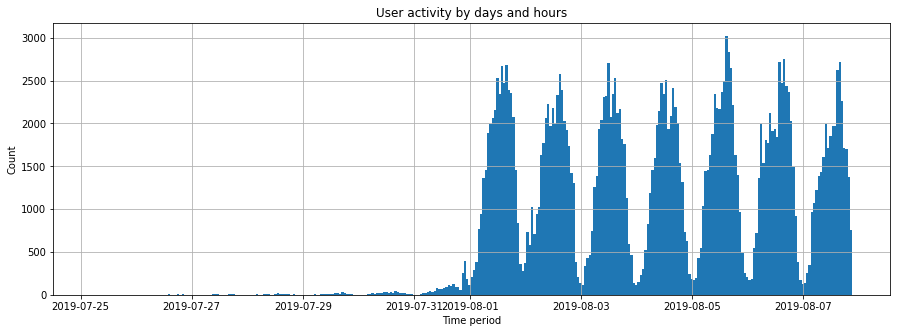

In [ ]:
bins = round((logs['timestamp'].max() - logs['timestamp'].min()).total_seconds() / (60 * 60))
logs['timestamp'].hist(bins=bins, figsize=(15,5))
plt.title('User activity by days and hours')
plt.xlabel('Time period')
plt.ylabel('Count')
plt.show()

We have a more detailed view on users activity by date and time of the day. There are some conclusions to be made:
1. Eeraly morning hours and late night are the low activity time.
2. The evening hours on the 31-st of July are similar to the dates with a lot of data.
3. What about July 31-st? There seems to be a transition there. The data in the evening of that date is almost the same amount as in evening hours of the days with a lot of data. Maybe there is a certein hour when the most observations are made?

In [ ]:
logs31 = logs[logs['date'] == dt.date(2019, 7, 31)]

In [ ]:
logs31['time'].describe()

count     2030    
unique    1861    
top       21:21:36
freq      4       
Name: time, dtype: object

We have most of actions made around 21.00, so we will take it to the next step of the analysis as well.

In [ ]:
df = logs[logs['timestamp'] > dt.datetime(2019, 7, 31, 21, 0, 0)]

In [ ]:
print("{} rows and {} user id's were eliminated from the analysis."\
      .format(len(logs) - len(df), logs['uid']\
      .nunique() - df['uid'].nunique()))
print('The share of rows loss: {:.1%}'.format(1 - (len(df) / len(logs))))

1989 rows and 13 user id's were eliminated from the analysis.
The share of rows loss: 0.8%


We need to make sure we have users from all three experimental groups.

In [ ]:
df.groupby(['group'], as_index=False)['uid'].nunique()

,group,uid
0,A1,2484
1,A2,2517
2,B,2537


All three groups have aproximatly even amount of unique users.
In addition we are checking that the users are unique to their groups.

In [ ]:
df.groupby(['uid'], as_index=False)['group'].nunique().sort_values(by='group', ascending=False)

,uid,group
0,6888746892508752,1
5021,6207091767962101846,1
5033,6217295124800833842,1
5032,6216080220799726690,1
5031,6215559225876063378,1
...,...,...
2508,3171891164497446149,1
2507,3171454373076660766,1
2506,3170212200647575044,1
2505,3167974726645136146,1


Looks like the users were assigned in a proper way: each user belongs to one unique group.

## Step 4. Study the event funnel


---



In [ ]:
# See what events are in the logs and their frequency of occurrence. Sort them by frequency
events_counts = df.groupby(['event_name'], as_index=False)['uid'].count().sort_values(by='uid', ascending=False)
events_counts

,event_name,uid
1,MainScreenAppear,117889
2,OffersScreenAppear,46531
0,CartScreenAppear,42343
3,PaymentScreenSuccessful,33951
4,Tutorial,1010


There are 5 events in the log, the most frequent is `MainScreenAppear`, followed by `OffersScreenAppear`, then the `CartScreenAppear`, and finally the `PaymentScreenSuccessful`. These 4 events are lined up in what seems to be a logical sequence. The least frequent event - the `Tutorial` - can occur at any stage of interaction with the application and will not be mandatory in the checkout event chain, so it will not be included in our event funnel analysis. 

Lets' **find the number of users who performed each of these actions.**

In [ ]:
# Eliminate Tutorial from funnel analysis
df = df[df['event_name'] != 'Tutorial']

In [ ]:
# Create a dataframe for studying the funnel, group by events
# Count the actions
# Count the unique users
# Sort by the highest number of unique users
funnel_df = df.groupby(['event_name'])\
              .agg({'timestamp':'count', 'uid':'nunique'})\
              .sort_values(by='uid', ascending=False)\
              .reset_index()
# Rename columns
funnel_df.columns = ['event_name', 'n_events', 'n_users']
funnel_df

,event_name,n_events,n_users
0,MainScreenAppear,117889,7423
1,OffersScreenAppear,46531,4597
2,CartScreenAppear,42343,3736
3,PaymentScreenSuccessful,33951,3540


Lets' find the number of users who performed each of these actions and sort the events by the number of users. We need to calculate the proportion of users who performed the action at least once.

In [ ]:
# Count the number of events per each user
events_per_user = df.groupby(['uid'], as_index=False)['event_name'].nunique()

In [ ]:
# Leave only the rows where the number of events equals to or greater than 1
events_per_user[events_per_user['event_name'] >= 1]\
              .sort_values(by='event_name')

,uid,event_name
0,6888746892508752,1
3915,4856890444852090984,1
3916,4857087115411142922,1
3917,4858477632114370688,1
3921,4863709363519372038,1
...,...,...
3014,3789964060786957254,4
5003,6189023996799334550,4
5004,6191352955702946968,4
5006,6192086126311273295,4


In [ ]:
events_per_user['uid'].nunique()

7534

The users that performed an action at least once is basicly all of our users. 

Lets' calculate the proprtions.

In [ ]:
# Calculate share of number of unique users per event to the total number of users
funnel_df['proportion'] = funnel_df['n_users'] / events_per_user['uid'].nunique()

In [ ]:
# Calculate average evetnts per users for each event
funnel_df['event_per_user'] = funnel_df['n_events'] / funnel_df['n_users']

In [ ]:
funnel_df

,event_name,n_events,n_users,proportion,event_per_user
0,MainScreenAppear,117889,7423,0.99,15.88
1,OffersScreenAppear,46531,4597,0.61,10.12
2,CartScreenAppear,42343,3736,0.50,11.33
3,PaymentScreenSuccessful,33951,3540,0.47,9.59


- **98%** of all users visited the **main screen**, 7419 users made 117328 actions, each user visited the main screen 15-16 times on average

- **61%** read the **offer**, 4593 users read the offer 46333 times, each user visited that screen 10 times on average

- **50%** of users added something to the **cart**

- **47%** users in fact made the **purchase**

- **11%** watched the **tutorial**, 840 users watched the tutorial 1005, on average more than once - may mean that they don't understand the tutorial and come back to rewatch it.
Because we don't really know at what stage the tutorial appears, and it can probably played at any stage of the sequence, we will not take it into account.

In [ ]:
funnel_df_ = funnel_df[0:4][['event_name', 'n_users']]
funnel_df_

,event_name,n_users
0,MainScreenAppear,7423
1,OffersScreenAppear,4597
2,CartScreenAppear,3736
3,PaymentScreenSuccessful,3540


In [ ]:
funnel_df_['shift_percent'] = (funnel_df_['n_users'] / funnel_df_['n_users'].shift(1))
funnel_df_['percent_of_initial'] = (funnel_df_['n_users'] / funnel_df_.loc[0]['n_users'])
funnel_df_['users_loss'] = (funnel_df_['n_users'] - funnel_df_['n_users'].shift(1))
funnel_df_

,event_name,n_users,shift_percent,percent_of_initial,users_loss
0,MainScreenAppear,7423,NaN,1.00,NaN
1,OffersScreenAppear,4597,0.62,0.62,-2826.00
2,CartScreenAppear,3736,0.81,0.50,-861.00
3,PaymentScreenSuccessful,3540,0.95,0.48,-196.00


Now we can track the shifting of the number of users and events change in dynamics:
- The column `users_loss` shows the number of users lost from the previous row 
- The column `percent_of_initial` show the same loss in percents
- The column `shift_percent` shows the relative share from each previous row.

Lets show the `shift_percent` on a funnel plot:

In [ ]:
fig = go.Figure(go.Funnel(y=funnel_df_['event_name'], 
                          x=funnel_df_['n_users'], textinfo = "value+percent previous",
                          opacity = 0.65, marker = {"color": "silver"}))
fig.update_layout(autosize=False, width=900, height=300, 
                  margin=go.layout.Margin(l=50, r=50, b=0, t=50, pad=4))
fig.update_layout(title='Events funel', title_x=0.55)
fig.show()

After seeing the **mainscreen** **62%** of users continued to the offers screen, we lost *38%* of users in that step

But after the **offer screen 81%** users continued to the cart, the loss here is only *19%*

After adding something to the **cart 95%** of users actually made the purchase, or in other words, 

**5% of the users didn't accomplish the purchase** leaving the products in the cart.




This time, **lets' actually consider the sequence of the actions and track the users that followed the sequence.**

In [ ]:
# Find the minimum timestamp for each user as the first or the only one visit of each user
sequence_users = df.pivot_table(
                index='uid', 
                columns='event_name', 
                values='timestamp', 
                aggfunc='min')
sequence_users

event_name,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful
uid,,,,
6888746892508752,NaT,2019-08-06 14:06:34,NaT,NaT
6909561520679493,2019-08-06 18:52:58,2019-08-06 18:52:54,2019-08-06 18:53:04,2019-08-06 18:52:58
6922444491712477,2019-08-04 14:19:40,2019-08-04 14:19:33,2019-08-04 14:19:46,2019-08-04 14:19:40
7435777799948366,NaT,2019-08-05 08:06:34,NaT,NaT
7702139951469979,2019-08-02 14:28:45,2019-08-01 04:29:54,2019-08-01 04:29:56,2019-08-02 14:28:45
...,...,...,...,...
9217594193087726423,2019-08-02 09:00:58,NaT,2019-08-02 09:01:08,2019-08-02 09:00:57
9219463515465815368,2019-08-06 16:49:40,2019-08-05 05:26:26,2019-08-06 16:48:57,2019-08-06 16:52:16
9220879493065341500,2019-08-02 17:59:16,2019-08-02 17:58:48,2019-08-02 17:59:00,NaT


So we see, that some users made several actions, some made just one, in other words, the timestemps follow different paths. It will be good to know, how much time on average would it take a user to make their way from the main screen to the payment screen.

In [ ]:
# Place the columns in the supposed order of the events
sequence_users_ordered = sequence_users[['MainScreenAppear', 'OffersScreenAppear', 
                                         'CartScreenAppear', 'PaymentScreenSuccessful']]

In [ ]:
# Shift columns to calculate differnce between time in events
sequence_users_ordered = sequence_users_ordered.shift(+1, axis=1)
sequence_users_ordered

event_name,MainScreenAppear,OffersScreenAppear,CartScreenAppear,PaymentScreenSuccessful
uid,,,,
6888746892508752,NaT,2019-08-06 14:06:34,NaT,NaT
6909561520679493,NaT,2019-08-06 18:52:54,2019-08-06 18:53:04,2019-08-06 18:52:58
6922444491712477,NaT,2019-08-04 14:19:33,2019-08-04 14:19:46,2019-08-04 14:19:40
7435777799948366,NaT,2019-08-05 08:06:34,NaT,NaT
7702139951469979,NaT,2019-08-01 04:29:54,2019-08-01 04:29:56,2019-08-02 14:28:45
...,...,...,...,...
9217594193087726423,NaT,NaT,2019-08-02 09:01:08,2019-08-02 09:00:58
9219463515465815368,NaT,2019-08-05 05:26:26,2019-08-06 16:48:57,2019-08-06 16:49:40
9220879493065341500,NaT,2019-08-02 17:58:48,2019-08-02 17:59:00,2019-08-02 17:59:16


In [ ]:
# Leave only events of interest
sequence_users_ordered = sequence_users[['MainScreenAppear', 'PaymentScreenSuccessful']]

In [ ]:
# Calculate the differnce
sequence_users_ordered_ = sequence_users_ordered - sequence_users_ordered.shift(+1, axis=1)
sequence_users_ordered_

event_name,MainScreenAppear,PaymentScreenSuccessful
uid,,
6888746892508752,NaT,NaT
6909561520679493,NaT,0 days 00:00:04
6922444491712477,NaT,0 days 00:00:07
7435777799948366,NaT,NaT
7702139951469979,NaT,1 days 09:58:51
...,...,...
9217594193087726423,NaT,NaT
9219463515465815368,NaT,1 days 11:25:50
9220879493065341500,NaT,NaT


In [ ]:
print('On average users get to the payment screen from the main screen in {}'\
      .format(sequence_users_ordered_['PaymentScreenSuccessful'].mean()))

On average users get to the payment screen from the main screen in 0 days 12:48:47.202208018


Lets' follow our users' steps to find out what could be the most common sequence of interraction with the app. We take one experimental randomly chosen user and see how he behaved.

In [ ]:
df.sample()

,event_name,uid,timestamp,group,date,time
122044,MainScreenAppear,6614985746798545862,2019-08-04 11:49:26,A1,2019-08-04,11:49:26


In [ ]:
df[df['uid'] == 5378506390650869352]

,event_name,uid,timestamp,group,date,time
5719,MainScreenAppear,5378506390650869352,2019-08-01 05:39:39,B,2019-08-01,05:39:39
5755,OffersScreenAppear,5378506390650869352,2019-08-01 05:42:17,B,2019-08-01,05:42:17
5934,OffersScreenAppear,5378506390650869352,2019-08-01 05:51:19,B,2019-08-01,05:51:19
5936,OffersScreenAppear,5378506390650869352,2019-08-01 05:51:29,B,2019-08-01,05:51:29
5947,CartScreenAppear,5378506390650869352,2019-08-01 05:51:38,B,2019-08-01,05:51:38
...,...,...,...,...,...,...
214197,MainScreenAppear,5378506390650869352,2019-08-07 03:51:58,B,2019-08-07,03:51:58
214201,OffersScreenAppear,5378506390650869352,2019-08-07 03:52:03,B,2019-08-07,03:52:03
224137,MainScreenAppear,5378506390650869352,2019-08-07 10:40:03,B,2019-08-07,10:40:03
224147,OffersScreenAppear,5378506390650869352,2019-08-07 10:40:33,B,2019-08-07,10:40:33


Lets' build a function that can look through subsets for each users' actions log and will make a sorted list of actions in order of their appearence.

In [ ]:
def sequence(user):
    sorted_user = df[df['uid'] == user].sort_values(by=['uid', 'timestamp'])
    return df['event_name'].drop_duplicates().to_list()

In [ ]:
# Check function
sequence(5378506390650869352)

['MainScreenAppear',
 'OffersScreenAppear',
 'PaymentScreenSuccessful',
 'CartScreenAppear']

Now we can apply this function to all our users, write down each ones' sequence and among those sequences find the most frequent one.

In [ ]:
sequence_empty = []
for i in df.uid.unique():
    sequence_empty.append([i, sequence(i)])

In [ ]:
sequence_empty

In [ ]:
patterns = pd.DataFrame(sequence_empty, columns=['user','pattern'])
patterns

,user,pattern
0,7701922487875823903,"[MainScreenAppear, OffersScreenAppear, PaymentScreenSuccessful, CartScreenAppear]"
1,2539077412200498909,"[MainScreenAppear, OffersScreenAppear, PaymentScreenSuccessful, CartScreenAppear]"
2,3286987355161301427,"[MainScreenAppear, OffersScreenAppear, PaymentScreenSuccessful, CartScreenAppear]"
3,3187166762535343300,"[MainScreenAppear, OffersScreenAppear, PaymentScreenSuccessful, CartScreenAppear]"
4,1118952406011435924,"[MainScreenAppear, OffersScreenAppear, PaymentScreenSuccessful, CartScreenAppear]"
...,...,...
7529,5811573131275421338,"[MainScreenAppear, OffersScreenAppear, PaymentScreenSuccessful, CartScreenAppear]"
7530,5365227480683749189,"[MainScreenAppear, OffersScreenAppear, PaymentScreenSuccessful, CartScreenAppear]"
7531,6660805781687343085,"[MainScreenAppear, OffersScreenAppear, PaymentScreenSuccessful, CartScreenAppear]"
7532,7823752606740475984,"[MainScreenAppear, OffersScreenAppear, PaymentScreenSuccessful, CartScreenAppear]"


In [ ]:
patterns.describe(include='object')

,pattern
count,7534
unique,1
top,"[MainScreenAppear, OffersScreenAppear, PaymentScreenSuccessful, CartScreenAppear]"
freq,7534


We need to relocate our users to a new dataframe and set a step by step sequence according to the pattern:
>  `MainScreenAppear` -> `OffersScreenAppear` -> `CartScreenAppear` -> `PaymentScreenSuccessful`.

In [ ]:
# Create an empty table where we will aggregate 
steps = pd.DataFrame(columns=['step', 'n_users', 'shift_percent', 'percent_of_initial'])
steps['step'] = ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']
steps

,step,n_users,shift_percent,percent_of_initial
0,MainScreenAppear,NaN,NaN,NaN
1,OffersScreenAppear,NaN,NaN,NaN
2,CartScreenAppear,NaN,NaN,NaN
3,PaymentScreenSuccessful,NaN,NaN,NaN


In [ ]:
step_1 = sequence_users['MainScreenAppear'].notna() # find all rows that have values from the dataframe with minimum timestamp as a boolean mask
step_2 = step_1 & (sequence_users['OffersScreenAppear'] > sequence_users['MainScreenAppear']) # add the users, whos' timestamp was later than on previous step
step_3 = step_2 & (sequence_users['CartScreenAppear'] > sequence_users['OffersScreenAppear']) # repeat
step_4 = step_3 & (sequence_users['PaymentScreenSuccessful'] > sequence_users['CartScreenAppear']) # repeat
# Sum up the masks and apply them to the dataframe, save as the number of users
steps['n_users']  = [len(sequence_users[step_1]), len(sequence_users[step_2]), len(sequence_users[step_3]), len(sequence_users[step_4])]

In [ ]:
steps

,step,n_users,shift_percent,percent_of_initial
0,MainScreenAppear,7423,NaN,NaN
1,OffersScreenAppear,4203,NaN,NaN
2,CartScreenAppear,1781,NaN,NaN
3,PaymentScreenSuccessful,458,NaN,NaN


In [ ]:
steps['users_loss'] = steps['n_users'] - steps['n_users'].shift(1) # calculate the loss of users from each previous step
steps['shift_percent'] = steps['n_users'] / steps['n_users'].shift(1) # calculate the share of users from each previous step
steps.loc[0, ['shift_percent']] = 1 # establish the first event as 100% share
steps['percent_of_initial'] = steps['n_users'] / steps.loc[0, ['n_users']][0] # calculate the share of users only from the initial event

In [ ]:
steps

,step,n_users,shift_percent,percent_of_initial,users_loss
0,MainScreenAppear,7423,1.00,1.00,NaN
1,OffersScreenAppear,4203,0.57,0.57,-3220.00
2,CartScreenAppear,1781,0.42,0.24,-2422.00
3,PaymentScreenSuccessful,458,0.26,0.06,-1323.00


In [ ]:
fig = go.Figure(go.Funnel(y=steps['step'], x=steps['n_users'], textinfo = "value+percent initial",
    opacity = 0.65, marker = {"color": "silver"}))
fig.update_layout(autosize=False, width=900, height=300, 
                  margin=go.layout.Margin(l=50, r=50, b=0, t=50, pad=4))

fig.update_layout(title='Sequential event funnel', title_x=0.6)
fig.show()

Out of **100%** of users that saw the **main screen**:
 * **57%** get to the **offer** screen,
 * **24%** get to the **cart**
 * and only **6%** make it to the **payment** screen

**Inremediate conclusion**

---



We analyzed the funnel of events we concidered the sequence that describes the interaction between the user and the application in the best logical way:
1. Appearance of the main screen (MainScreenAppear)
1. The appearance of the screen with the offer of goods (OffersScreenAppear)
1. The appearance of the screen with the basket (CartScreenAppear)
1. The appearance of the successful payment screen (PaymentScreenSuccessful)
1. The least popular event - the opening of the tutorial (Tutorial) - was not included in the funnel due to its optionality.

An analysis of the funnel of events showed:

- **2%** of users get into the application having missed the main screen,

- **11%** of users use the tutorial
- the least users loss was observed in between steps `MainScreenAppear` and `OfferScreenAppear`, where **38%** of the users didn't follow the next step.
- the percentage of users that made the purchase in relation to the number of users who saw the main screen, was almost 2 times less;
- taking into account the sequence of events, about half of users follow to each next step (**57%** from the first step, **42%** from the second to the third step), however when following to the last step, only a quarter of those who added something to the cart successfully made the purchase
- taking into account the sequence of events, only **6%** of users reach to the step of making the purchase and completing the entire chain of steps.



##  Step 5. Study the results of the experiment


---





# A/A test

The main goal of an A/A test is to show whether the results of an experiment that will be run under the same conditions, but with different page variations (change of font in our case), *can be trusted*. If during the A/A test it was not possible to identify the winner, we can run our A/B test. Otherwise, we will have to check the settings of the service and the homogeneity of the sample. Thus, an A/A test provides benchmark data to check the accuracy of an A/B test.

In [ ]:
groups = df.groupby(['group'])['uid'].nunique()
groups

group
A1    2483
A2    2516
B     2535
Name: uid, dtype: int64

In [ ]:
print('The relative difference of the two control groups is {:.1%} users'.format(abs(groups['A2'] / groups['A1']) - 1))
print('The absolute difference of the two control groups is {:.0f} users'.format(abs(groups['A2'] - groups['A1'])))

The relative difference of the two control groups is 1.3% users
The absolute difference of the two control groups is 33 users


It visually seems that the differnce is not significant in the amount of users in the 3 groups. We need to test the hypothesys that the groups' proportions are the same. Lets' brake down the number of users by date.

In [ ]:
# Create an empty dataframe
groups_by_days = pd.DataFrame()
# Take the group name from groups df indexes and for each one 
# cumulate their amount from the original df 
# grouped by dates
for group in groups.index:
    groups_by_days[group] = df[df['group'] == group].groupby(['date'])['uid'].nunique()

In [ ]:
groups_by_days

,A1,A2,B
date,,,
2019-07-31,48,52,58
2019-08-01,1191,1282,1228
2019-08-02,1197,1220,1228
2019-08-03,1140,1174,1166
2019-08-04,1170,1169,1188
2019-08-05,1269,1263,1269
2019-08-06,1269,1320,1331
2019-08-07,1198,1212,1241


In [ ]:
# Make samples
sample1 = groups_by_days['A1'].values
sample2 = groups_by_days['A2'].values
sample3 = groups_by_days['B'].values

In [ ]:
sample3

array([  58, 1228, 1228, 1166, 1188, 1269, 1331, 1241])

In [ ]:
def testing_average(sample1, sample2, alpha = 0.05):
    # checking normality
    stat1, p1_norm = stats.shapiro(sample1)
    stat2, p2_norm = stats.shapiro(sample2)
    # if distribution is normall
    if p1_norm > alpha and p2_norm > alpha:
        print('According to Shapiro test both samples are normally distributed, perform Levenes test and t-test.')
        # for t-test also should check the equality of variances
        statslev, p_levene = stats.levene(sample1, sample2)
        if p_levene < alpha:
            # variances are not equal
            statist, p_value = stats.ttest_ind(sample1, sample2, equal_var=False)
            print('According to Levenes test variances are not equal')
        else:
            statist, p_value = stats.ttest_ind(sample1, sample2, equal_var=True)
            print('According to Levenes test variances are equal') 
    # if not normal apply non-parametric test
    else:
        print('Perform Mann-Whitney test')
        statist, p_value = stats.mannwhitneyu(sample1, sample2)
    
    print('t-test p value', p_value)
    
    if p_value < alpha:
        print('Reject H0, the samples are different')
    else:
        print('Fail to Reject H0, the samples are not different')

In [ ]:
# with 0.5 significance level
testing_average(sample1, sample2, alpha=0.05)

Perform Mann-Whitney test
t-test p value 0.21527894382232682
Fail to Reject H0, the samples are not different


In [ ]:
# with 0.1 significance level
testing_average(sample1, sample2, alpha=0.01)

Perform Mann-Whitney test
t-test p value 0.21527894382232682
Fail to Reject H0, the samples are not different


**With 95% and 99% confidence we can state that samples A1 and A2 are not different in a statisticaly significant way.**

For the full picture lets' test all the three groups in three pairs.
We will be testing the hypothesis about the equality of the average number of users in each pair of samples using the **t-test**, we use this test, because we are checking the equality of the mean. Since the samples are independent of each other (that is, it means that there are different people in these groups, as we saw when analyzing the distribution by groups), we apply the two-sided `scipy.stats.ttest_ind` test.

Paired comparisons increase the likelihood of a false positive result. To reduce the probability of type I error and adjust the required level of significance (${\alpha} = 0.05$), we apply the lower level of significance (${\alpha} = 0.01$) as well to balance the result. 

In [ ]:
# Establish the level of significance
alpha = 0.05
lower_alpha = 0.01

In [ ]:
# With a = 0.05
for a, b in [['A1', 'A2'], ['A2', 'B'], ['A1', 'B']]:
    print('H0: number of users in groups {} and {} ARE NOT DIFFERENT'.format(a, b))
    print('H1: number of users in groups {} и {} ARE DIFFERNT'.format(a, b))
    results =  stats.ttest_ind(groups_by_days[a], groups_by_days[b])
    print('p-value for groups {} and {}: {}'.format(a, b, results.pvalue))
    
    if results.pvalue < alpha:
        print('Reject H0')
    else:
        print('Failed to reject H0')
        print()

H0: number of users in groups A1 and A2 ARE NOT DIFFERENT
H1: number of users in groups A1 и A2 ARE DIFFERNT
p-value for groups A1 and A2: 0.9014538349141006
Failed to reject H0

H0: number of users in groups A2 and B ARE NOT DIFFERENT
H1: number of users in groups A2 и B ARE DIFFERNT
p-value for groups A2 and B: 0.9920753758227221
Failed to reject H0

H0: number of users in groups A1 and B ARE NOT DIFFERENT
H1: number of users in groups A1 и B ARE DIFFERNT
p-value for groups A1 and B: 0.8932927051504511
Failed to reject H0



In [ ]:
# With a = 0.01
for a, b in [['A1', 'A2'], ['A2', 'B'], ['A1', 'B']]:
    print('H0: number of users in groups {} and {} ARE NOT DIFFERENT'.format(a, b))
    print('H1: number of users in groups {} и {} ARE DIFFERNT'.format(a, b))
    results =  stats.ttest_ind(groups_by_days[a], groups_by_days[b])
    print('p-value for groups {} and {}: {}'.format(a, b, results.pvalue))
    
    if results.pvalue < lower_alpha:
        print('Reject H0')
    else:
        print('Failed to reject H0')
        print()

H0: number of users in groups A1 and A2 ARE NOT DIFFERENT
H1: number of users in groups A1 и A2 ARE DIFFERNT
p-value for groups A1 and A2: 0.9014538349141006
Failed to reject H0

H0: number of users in groups A2 and B ARE NOT DIFFERENT
H1: number of users in groups A2 и B ARE DIFFERNT
p-value for groups A2 and B: 0.9920753758227221
Failed to reject H0

H0: number of users in groups A1 and B ARE NOT DIFFERENT
H1: number of users in groups A1 и B ARE DIFFERNT
p-value for groups A1 and B: 0.8932927051504511
Failed to reject H0



With groups A2 ad B the probability of similarity is alomost 95%, within groups A1 and A2, A1 and B such probability is also high, thus we conclude that the samples means are not different in a significant way.

Lets' select the most popular event. In each of the control groups, we will find the number of users who performed this action and calculate their share. We wil check whether the difference between the groups is statistically significant. We need to repeat the procedure for all events, to make this task easier we can build a function and automate the process.

To choose users according to events we will take the filtered dataframe and pull out values from it to a new table.

In [ ]:
# Create an empty dataframe
groups_by_events = pd.DataFrame()
# Take the group name from groups df indexes and for each one 
# cumulate their amount from the original df 
# grouped by events
for group in groups.index:
    groups_by_events[group] = (df[df['group'] == group]
                                .groupby('event_name')['uid'].nunique())

In [ ]:
groups_by_events

,A1,A2,B
event_name,,,
CartScreenAppear,1266,1239,1231
MainScreenAppear,2450,2479,2494
OffersScreenAppear,1542,1524,1531
PaymentScreenSuccessful,1200,1158,1182


In [ ]:
groups

group
A1    2483
A2    2516
B     2535
Name: uid, dtype: int64

In [ ]:
# Append the groups total amount for easier calculations
groups_by_events = groups_by_events.append(groups)

In addition to the absolute values of the number of users in groups, we need to know the shares they have.

In [ ]:
groups_by_events

,A1,A2,B
event_name,,,
CartScreenAppear,1266,1239,1231
MainScreenAppear,2450,2479,2494
OffersScreenAppear,1542,1524,1531
PaymentScreenSuccessful,1200,1158,1182
uid,2483,2516,2535


In [ ]:
# Take each columns' value and devide it by the value in the uid cell as the total
for col in groups_by_events.columns:
    groups_by_events[str(col)+'_share'] = groups_by_events[col] / groups_by_events.loc['uid'][col]


In [ ]:
# Rename the columns
groups_by_events.index = ['CartScreenAppear', 'MainScreenAppear', 'OffersScreenAppear',
       'PaymentScreenSuccessful', 'Total']

In [ ]:
groups_by_events

,A1,A2,B,A1_share,A2_share,B_share
CartScreenAppear,1266,1239,1231,0.51,0.49,0.49
MainScreenAppear,2450,2479,2494,0.99,0.99,0.98
OffersScreenAppear,1542,1524,1531,0.62,0.61,0.60
PaymentScreenSuccessful,1200,1158,1182,0.48,0.46,0.47
Total,2483,2516,2535,1.00,1.00,1.00


In [ ]:
# Check access
groups_by_events.loc['PaymentScreenSuccessful']['A1']

1200.0

To see if there was a statistically significant differences in users behavior, we will test the hypotheses about the equality of conversions of events. In other words, we will test the hypotheses about the equality of shares in two samples by applying the z-test.

As before, we apply a correction for multiple comparisons to reduce the likelihood of a false positive result. We will build another function that will take the names of the groups we will compare and the name of the event. 

**For each pair of groups (A1/A2, A1/B, A2/B, A/B) 5 tests will take place**.

In [ ]:
def z_function(a, b, df, event, alpha):
  print('H0: events {} in groups {} and {} are not different'.format(event, a, b))
  print('H1: the difference of share of event {} in groups {} and {} is statistically significant'.format(event, a, b))
  s1 = df.loc[event][a]    #  number of successes   sample А
  t1 = df.loc['Total'][a]  #  number of trials      sample А
  s2 = df.loc[event][b]    #  number of successes   sample B
  t2 = df.loc['Total'][b]  #  number trials         sample B
  z, p_value = sm.stats.proportions_ztest([s1, s2], [t1, t2])
  if p_value < alpha:
    print('The samples are different, reject the null hypothesys')
    print('p-value:{}'.format(p_value))
  else:
    print('There is no difference, failed to reject null hypothesis')
    print('p-value: {}'.format(p_value))

In [ ]:
# Test when alpha = 0.05
for event in ['CartScreenAppear', 'MainScreenAppear', 'OffersScreenAppear',
       'PaymentScreenSuccessful']:
       z_function('A1', 'A2', groups_by_events, event, alpha)
       print('-'*110)
       print()

H0: events CartScreenAppear in groups A1 and A2 are not different
H1: the difference of share of event CartScreenAppear in groups A1 and A2 is statistically significant
There is no difference, failed to reject null hypothesis
p-value: 0.21811883651016095
--------------------------------------------------------------------------------------------------------------

H0: events MainScreenAppear in groups A1 and A2 are not different
H1: the difference of share of event MainScreenAppear in groups A1 and A2 is statistically significant
There is no difference, failed to reject null hypothesis
p-value: 0.6702082653142836
--------------------------------------------------------------------------------------------------------------

H0: events OffersScreenAppear in groups A1 and A2 are not different
H1: the difference of share of event OffersScreenAppear in groups A1 and A2 is statistically significant
There is no difference, failed to reject null hypothesis
p-value: 0.2667347868697105
---------

In [ ]:
# Test when alpha = 0.01
for event in ['CartScreenAppear', 'MainScreenAppear', 'OffersScreenAppear',
       'PaymentScreenSuccessful']:
       z_function('A1', 'A2', groups_by_events, event, lower_alpha)
       print('-'*110)
       print()

H0: events CartScreenAppear in groups A1 and A2 are not different
H1: the difference of share of event CartScreenAppear in groups A1 and A2 is statistically significant
There is no difference, failed to reject null hypothesis
p-value: 0.21811883651016095
--------------------------------------------------------------------------------------------------------------

H0: events MainScreenAppear in groups A1 and A2 are not different
H1: the difference of share of event MainScreenAppear in groups A1 and A2 is statistically significant
There is no difference, failed to reject null hypothesis
p-value: 0.6702082653142836
--------------------------------------------------------------------------------------------------------------

H0: events OffersScreenAppear in groups A1 and A2 are not different
H1: the difference of share of event OffersScreenAppear in groups A1 and A2 is statistically significant
There is no difference, failed to reject null hypothesis
p-value: 0.2667347868697105
---------

So, according to the results of our tests, we don't have enough grounds to consider the proportions of events to be different in the control groups, again we can conclude that the split into groups was made properly.

# A/B test

In [ ]:
# Test when alpha = 0.05
for event in ['CartScreenAppear', 'MainScreenAppear', 'OffersScreenAppear',
       'PaymentScreenSuccessful',]:
       z_function('A1', 'B', groups_by_events, event, alpha)
       print('-'*110)
       print()

H0: events CartScreenAppear in groups A1 and B are not different
H1: the difference of share of event CartScreenAppear in groups A1 and B is statistically significant
There is no difference, failed to reject null hypothesis
p-value: 0.08564271892834718
--------------------------------------------------------------------------------------------------------------

H0: events MainScreenAppear in groups A1 and B are not different
H1: the difference of share of event MainScreenAppear in groups A1 and B is statistically significant
There is no difference, failed to reject null hypothesis
p-value: 0.39691004961815113
--------------------------------------------------------------------------------------------------------------

H0: events OffersScreenAppear in groups A1 and B are not different
H1: the difference of share of event OffersScreenAppear in groups A1 and B is statistically significant
There is no difference, failed to reject null hypothesis
p-value: 0.21442476639710495
-------------

In [ ]:
# Test when alpha = 0.01
for event in ['CartScreenAppear', 'MainScreenAppear', 'OffersScreenAppear',
       'PaymentScreenSuccessful']:
       z_function('A1', 'B', groups_by_events, event, lower_alpha)
       print('-'*110)
       print()

H0: events CartScreenAppear in groups A1 and B are not different
H1: the difference of share of event CartScreenAppear in groups A1 and B is statistically significant
There is no difference, failed to reject null hypothesis
p-value: 0.08564271892834718
--------------------------------------------------------------------------------------------------------------

H0: events MainScreenAppear in groups A1 and B are not different
H1: the difference of share of event MainScreenAppear in groups A1 and B is statistically significant
There is no difference, failed to reject null hypothesis
p-value: 0.39691004961815113
--------------------------------------------------------------------------------------------------------------

H0: events OffersScreenAppear in groups A1 and B are not different
H1: the difference of share of event OffersScreenAppear in groups A1 and B is statistically significant
There is no difference, failed to reject null hypothesis
p-value: 0.21442476639710495
-------------

In [ ]:
# Test when alpha = 0.05
for event in ['CartScreenAppear', 'MainScreenAppear', 'OffersScreenAppear',
       'PaymentScreenSuccessful']:
       z_function('A2', 'B', groups_by_events, event, alpha)
       print('-'*110)
       print()

H0: events CartScreenAppear in groups A2 and B are not different
H1: the difference of share of event CartScreenAppear in groups A2 and B is statistically significant
There is no difference, failed to reject null hypothesis
p-value: 0.6264599792848009
--------------------------------------------------------------------------------------------------------------

H0: events MainScreenAppear in groups A2 and B are not different
H1: the difference of share of event MainScreenAppear in groups A2 and B is statistically significant
There is no difference, failed to reject null hypothesis
p-value: 0.672316770476623
--------------------------------------------------------------------------------------------------------------

H0: events OffersScreenAppear in groups A2 and B are not different
H1: the difference of share of event OffersScreenAppear in groups A2 and B is statistically significant
There is no difference, failed to reject null hypothesis
p-value: 0.8971376549155397
-----------------

In [ ]:
# Test when alpha = 0.01
for event in ['CartScreenAppear', 'MainScreenAppear', 'OffersScreenAppear',
       'PaymentScreenSuccessful']:
       z_function('A2', 'B', groups_by_events, event, lower_alpha)
       print('-'*110)
       print()

H0: events CartScreenAppear in groups A2 and B are not different
H1: the difference of share of event CartScreenAppear in groups A2 and B is statistically significant
There is no difference, failed to reject null hypothesis
p-value: 0.6264599792848009
--------------------------------------------------------------------------------------------------------------

H0: events MainScreenAppear in groups A2 and B are not different
H1: the difference of share of event MainScreenAppear in groups A2 and B is statistically significant
There is no difference, failed to reject null hypothesis
p-value: 0.672316770476623
--------------------------------------------------------------------------------------------------------------

H0: events OffersScreenAppear in groups A2 and B are not different
H1: the difference of share of event OffersScreenAppear in groups A2 and B is statistically significant
There is no difference, failed to reject null hypothesis
p-value: 0.8971376549155397
-----------------

In [ ]:
# Unite groups A1 and A2, sum their number of events
groups_by_events['A'] = groups_by_events['A1'] + groups_by_events['A2']

In [ ]:
groups_by_events

,A1,A2,B,A1_share,A2_share,B_share,A
CartScreenAppear,1266,1239,1231,0.51,0.49,0.49,2505
MainScreenAppear,2450,2479,2494,0.99,0.99,0.98,4929
OffersScreenAppear,1542,1524,1531,0.62,0.61,0.60,3066
PaymentScreenSuccessful,1200,1158,1182,0.48,0.46,0.47,2358
Total,2483,2516,2535,1.00,1.00,1.00,4999


In [ ]:
# Calculate united A's share
groups_by_events['A_share'] = groups_by_events['A'] / groups_by_events.loc['Total']['A']

In [ ]:
groups_by_events

,A1,A2,B,A1_share,A2_share,B_share,A,A_share
CartScreenAppear,1266,1239,1231,0.51,0.49,0.49,2505,0.50
MainScreenAppear,2450,2479,2494,0.99,0.99,0.98,4929,0.99
OffersScreenAppear,1542,1524,1531,0.62,0.61,0.60,3066,0.61
PaymentScreenSuccessful,1200,1158,1182,0.48,0.46,0.47,2358,0.47
Total,2483,2516,2535,1.00,1.00,1.00,4999,1.00


In [ ]:
# Test when alpha = 0.05
for event in ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']:
    z_function('A', 'B', groups_by_events, event, alpha)
    print('-'*110)
    print()

H0: events MainScreenAppear in groups A and B are not different
H1: the difference of share of event MainScreenAppear in groups A and B is statistically significant
There is no difference, failed to reject null hypothesis
p-value: 0.4599468774918499
--------------------------------------------------------------------------------------------------------------

H0: events OffersScreenAppear in groups A and B are not different
H1: the difference of share of event OffersScreenAppear in groups A and B is statistically significant
There is no difference, failed to reject null hypothesis
p-value: 0.4303431159342346
--------------------------------------------------------------------------------------------------------------

H0: events CartScreenAppear in groups A and B are not different
H1: the difference of share of event CartScreenAppear in groups A and B is statistically significant
There is no difference, failed to reject null hypothesis
p-value: 0.2036135648145111
----------------------

In [ ]:
# Test when alpha = 0.01
for event in ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']:
    z_function('A', 'B', groups_by_events, event, lower_alpha)
    print('-'*110)
    print()

H0: events MainScreenAppear in groups A and B are not different
H1: the difference of share of event MainScreenAppear in groups A and B is statistically significant
There is no difference, failed to reject null hypothesis
p-value: 0.4599468774918499
--------------------------------------------------------------------------------------------------------------

H0: events OffersScreenAppear in groups A and B are not different
H1: the difference of share of event OffersScreenAppear in groups A and B is statistically significant
There is no difference, failed to reject null hypothesis
p-value: 0.4303431159342346
--------------------------------------------------------------------------------------------------------------

H0: events CartScreenAppear in groups A and B are not different
H1: the difference of share of event CartScreenAppear in groups A and B is statistically significant
There is no difference, failed to reject null hypothesis
p-value: 0.2036135648145111
----------------------

When compared to both of the control groups A1 and A2 and the united A group, the experimental group B showed no statistically significant difference in event shares.

To sum up, within the A/A/B experiment **16 tests** were performed  (4 groups of tests with 4 events each) - in this combination:

**pairs of comparisons:** A1/A2, A1/B, A2/B, A/B

**events:** `MainScreenAppear`, `OffersScreenAppear`, `CartScreenAppear`, `PaymentScreenSuccessful`.

In such cases the higher the alpha level of significance, the higher becomes the probability of a Type I error. Multiple pairwise comparisons increase the probability that the test will show a false positive result at some point, and to reduce this probability of error of the first type and adjust the required significance level alpha, a correction for multiple comparisons was applied and level of significance was lowered to 0.01.

Lets' vsualize our results:

In [ ]:
groups_by_events[1:4]

,A1,A2,B,A1_share,A2_share,B_share,A,A_share
MainScreenAppear,2450,2479,2494,0.99,0.99,0.98,4929,0.99
OffersScreenAppear,1542,1524,1531,0.62,0.61,0.60,3066,0.61
PaymentScreenSuccessful,1200,1158,1182,0.48,0.46,0.47,2358,0.47


In [ ]:
fig = make_subplots(rows=2, cols=2, shared_yaxes='all', subplot_titles=('A1', 'A2', 'B', 'A'))

fig.add_trace(go.Funnel(y=groups_by_events[1:4].index, x=groups_by_events[1:4]['A1'], 
                         textinfo = "value+percent initial", opacity = 0.65, 
                         marker = {"color": "grey"}), row=1, col=1)

fig.add_trace(go.Funnel(y=groups_by_events[1:4].index, x=groups_by_events[1:4]['A2'], 
                         textinfo = "value+percent initial", opacity = 0.65, 
                         marker = {"color": "green"}), row=1, col=2)

fig.add_trace(go.Funnel(y=groups_by_events[1:4].index, x=groups_by_events[1:4]['B'], 
                         textinfo = "value+percent initial", opacity = 0.65, 
                         marker = {"color": "red"}), row=2, col=1)

fig.add_trace(go.Funnel(y=groups_by_events[1:4].index, x=groups_by_events[1:4]['A'], 
                         textinfo = "value+percent initial", opacity = 0.65, 
                         marker = {"color": "blue"}), row=2, col=2)

fig.update_layout(autosize=False, width=900, height=500, 
                  margin=go.layout.Margin(l=0, r=40, b=0, t=50, pad=4), showlegend = False)

fig.update_layout(title='Event funnel of A/A/B experiment', title_x=0.5)


fig.show()

Based on the results of the A/A/B experiment, it was conducted that there were no statistically significant differences in the proportions of events in any of the analyzed groups at a 5% and 1% significance levels. That should mean, that changing the font did not affect the behavior of users, we can't say, that one of the fonts is certainly better than the other.

# General conclusions


---
The data provided for the analysis of the A/A/B experiment consisted of logs of users activity. After preprocessing the data: removed duplicates, changed data types and searching for outliers and anomalies this research found that in the period from July 25, 2019 till July 31-st, 2019 there was a very low amount of observatons, we eliminated this period and left with the first week of August (from August 1 to August 7, 2019). 
The split into groups was made properly.



Brief characteristics of the application: 

- There were 243713 actions in the log
- There were 7551 unique users
- Each user performed 20 events on average
- On average users made 17408 actions per day

The subjects of this analysis were:

* Event funnels,
* A/A/B-experiment of changing the font in the application.


**Recommendations:**

1. The logging algorythm needs to be checked (duplicates detected and an uneven amount of data in the given period)
1. The probability of usability problems should be concidered(11% refer to the tutorial, 16% returned to the it again)
1. It is to be made sure that there are no problems with moving from the main screen to the offer screen, or to be considered improving the main screen and working out the ux design (this is the stage, where we lose the largest number of users)
1. The payment screen must be checked as wells (only 6% of users who have completed all the steps in successfully paid for the order)
1. For future descisions - if the designers team decides to change the font, this change can be done without concern that there will be changes in user behavior (there is no statistically significant differences in the proportions of events in any of the groups analyzed).